# Teaching Practice

## Ordinary Least-Squares Estimation

G. Alexi Rodríguez-Arelis, **May 2022**

# Prerequisite Knowledge

This sample lecture teaches **the frequentist foundations of estimation in simple linear regression**. It would be part of the introductory material of **DSCI 561 (Regression I)**.

Before engaging in this lecture, students are expected to be familiar with topics taught in **DSCI 551 (Descriptive Statistics and Probability for Data Science)**, **DSCI 552 (Statistical Inference and Computation I)**, and **DSCI 531 (Data Visualization I)**. More specifically, with the following:

- Random variables, expected values (and their properties), and normality (DSCI 551).
- Estimators, sampling distributions, hypothesis testing, and confidence intervals (DSCI 552).
- Data visualization via `ggplot2` (DSCI 531).


# High-Level Learning Outcomes

By the end of the course, students are expected to attain the following:

- **Define linear regression models.**
- **Estimate their terms using `R` via a sample and interpret them.**
- Perform hypothesis testing for variable association.
- Use the estimated regression model for predictive purposes.
- Assess the in and out-sample prediction accuracy of a given estimated linear regression model.
- Perform model selection.
- Apply model diagnostics.

In [1]:
# Loading libraries and support functions
options(repr.matrix.max.rows = 8)
library(tidyverse)
library(bayesrules)
library(broom)
library(cowplot)
source("support_functions.R")
options(repr.plot.height = 6, repr.plot.width = 18)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Lecture Outline

1. Spotify versus Tidal!
2. The Conceptual Model
3. The Math!
4. Model Estimation
5. Modelling Results
6. Wrapping up

## 1. Spotify versus Tidal!

<br>
<center>        
<img src="https://cdn.mos.cms.futurecdn.net/JngPJcSyWhwWQ37S9odZvi-1024-80.jpg.webp" width="600" height="600"/>

*Source: [techradar.com](https://www.techradar.com/news/spotify-vs-tidal-which-music-streaming-service-is-best-for-you)*
</center>
<br>

The music streaming competition is real! Possibly, some of us are [Spotify](https://www.spotify.com/) subscribers. However, [Tidal](https://tidal.com/) is a strong competitor looking to attract more customers.

### 1.1. Main Statistical Inquiry

Suppose you are a Data Scientist at Tidal. Your team is interested in **quantifying** and **assessing** the **statistical dependence** of the **mean positivity/happiness** as a **FUNCTION** of the **danceability** within Spotify's music catalogue.

From Tidal's perspective, this potential statistical analysis will allow them **to have a benchmark for evaluating their whole catalogue on the same variables**.

### 1.2. The Dataset

As in any statistical analysis, **we need data**! Nonetheless, we will likely not access Spotify's population data (i.e., the whole catalogue with our variables of interest).

Therefore, our analysis will require **estimation** of population parameters via a given **sample**. Luckily, we can find different Spotify sample datasets online.

We will use the `spotify` dataset from the `bayesrules` package as **training data**. This dataset is a sample of 350 songs with different variables by column. We will assume this dataset is a **representative sample** of Spotify's catalogue.

In terms of our statistical inquiry, the `spotify` dataset provides these **key variables by song**:

- `danceability`:  a **continuous** score from 0 (not danceable) to 100 (danceable) based on features such as tempo, rhythm, etc.
- `valence`:  a **continuous** score from 0 (the song is more negative, sad, angry) to 100 (the song is more positive, happy, euphoric).

In [2]:
spotify_training <- spotify %>%
  select(title, danceability, valence)
spotify_training

title,danceability,valence
<chr>,<dbl>,<dbl>
On & On,74.7,67.0
All The Lies,70.7,63.4
Hear Me Now,77.8,49.6
The Wall,68.2,53.6
⋮,⋮,⋮
Stardust,65.9,25.4
Save My Grave,60.4,12.3
Shake,50.1,36.6
Sound Of The Underground,67.5,19.2


### 1.3. Exploratory Data Analysis

Let us proceed with the corresponding exploratory data analysis (EDA).

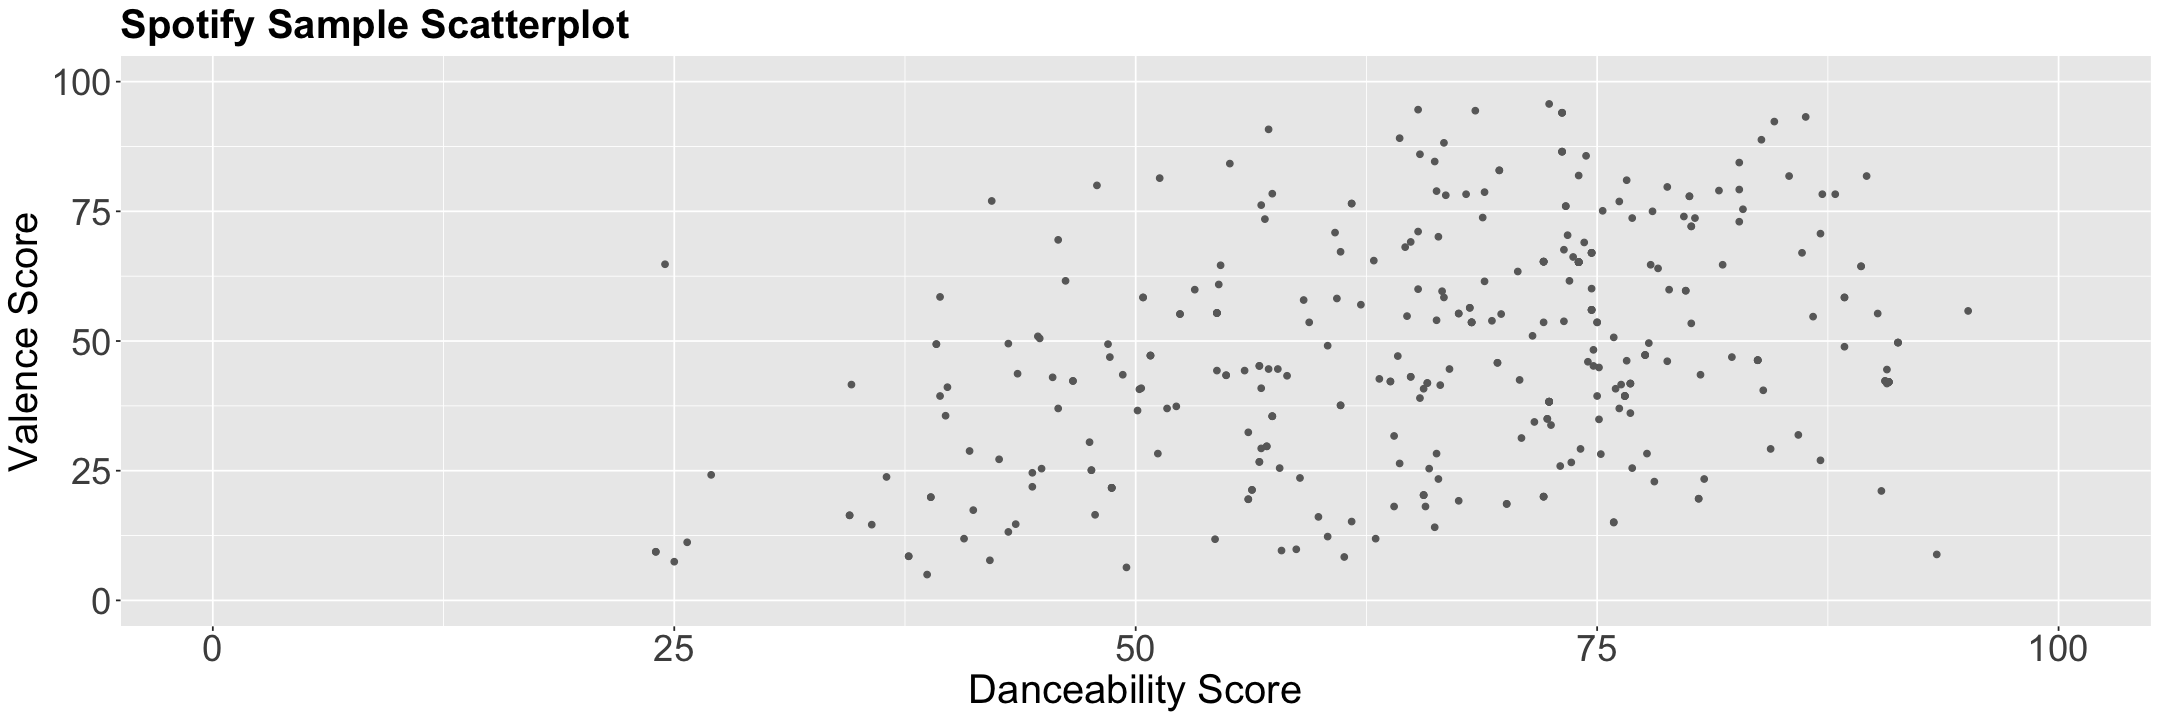

In [3]:
initial_scatterplot(data = spotify_training)

#### In-Class Question

What can we **graphically** say on the relationship between `danceability` and `valence`?

## 2. The Conceptual Model

A **foundational statistical tool** to address the main statistical inquiry is to use **simple linear regression**. This model includes a **response** (also known as endogenous or **dependent** variable) of **continuous** type. This response is subject to **regressors** (also known as exogenous variables, explanatory variables, etc.).

Conceptually, a linear regression model can be expressed as:

\begin{equation*}
\mbox{Response} = \mbox{Systematic Component} + \mbox{Random Component}
\end{equation*}


- The **systematic component** represents **the mean of the response**, which is **conditioned** on the **regressor values**. 
- The **random component** measures the extent to which the observed value of the response might deviate from its mean and is viewed as random noise. 

## 3. The Math!

An essential aspect of our statistical analysis is how we will mathematically model the data. Hence, we need to set up the modelling equation. Let us suppose that we have $n$ observations in our sample (i.e., songs in `spotify_training`). 

For the $i$th observation in our sample ($i = 1, \dots, n$), the conceptual model is mathematically represented as:

\begin{equation*}
\underbrace{Y_i}_\text{Response}  = \underbrace{\beta_0 + \beta_1 X_i}_\text{Systematic Component} + \underbrace{\varepsilon_i}_\text{Random Component}
\end{equation*}

Note the following:

- The response $Y_i$ is equal to the sum of $3$ terms on the right-hand side.
- The systematic component is the sum of:
    - An **unknown population** intercept $\beta_0$ and
    - The regressor $X_i$ is multiplied by an **unknown population** regression coefficient $\beta_1$.
    - $\varepsilon_i$ is the random component.  

This statistical model needs to make assumptions on the random component:

\begin{alignat*}{4}
&\text{Expected value:} \qquad& \mathbb{E}(\varepsilon_i) = 0\\
&\text{Common unknown variance:} \qquad& \text{Var}(\varepsilon_i) = \sigma^2 \\
&\text{Normality:} \qquad& \varepsilon_i \sim \mathcal{N}(0, \sigma^2) \\
&\text{Independence:} \qquad& \varepsilon_i \perp \!\!\! \perp \varepsilon_j \qquad \text{for} \; i \neq j
\end{alignat*}

> **Heads-up:** Once we train our model, these assumptions will pave the way to the stage called **inference**. Moreover, they need to be checked in a stage called **model diagnostics**.

#### In-Class Questions

Recall your main statistical inquiry:

> Your team is interested in **quantifying** and **assessing** the **statistical dependence** of the **mean positivity/happiness** as a **FUNCTION** of the **danceability** within Spotify's music catalogue.

The previous model is called **simple** linear regression. It is called **simple** since it involves a single regressor. Now, in terms of the main statistical inquiry and the variables `valence` and `danceability`:

1. What is the model's **response**?
2. What is the model's **regressor**?
3. What is the advantage of using a **LINEAR** systematic component to **quantify** the statistical dependence between the **response** and **regressor**?

#### Answers

1. The response is `valence`.
2. The regressor is `danceability`.
3. A key advantage of this simple linear regression is its interpretability. Specifically, the coefficient $\beta_1$ will indicate by **how much the `valence` will change by each unit increase in the regressor `danceability`**.

## 4. Model Estimation

We have already defined our modelling equation:

\begin{equation*}
Y_i  = \beta_0 + \beta_1 X_i + \varepsilon_i
\end{equation*}

Moreover, according to the main statistical inquiry, our simple linear regression aims to model the **conditional mean** of the response as follows:

\begin{equation*}
\mathbb{E}(Y_i \mid X_i = x_i) = \beta_0 + \beta_1 x_i \; \; \; \; \text{since} \; \; \; \; \mathbb{E}(\varepsilon_i) = 0.
\end{equation*}

> **Heads-up:** The conditional mean is key in this model. **We are conditioning the mean of our response on the values of our regressor as a linear equation on the right-hand side!**

Nevertheless, we do not know the population regression parameters $\beta_0$ and $\beta_1$! How can we estimate them?

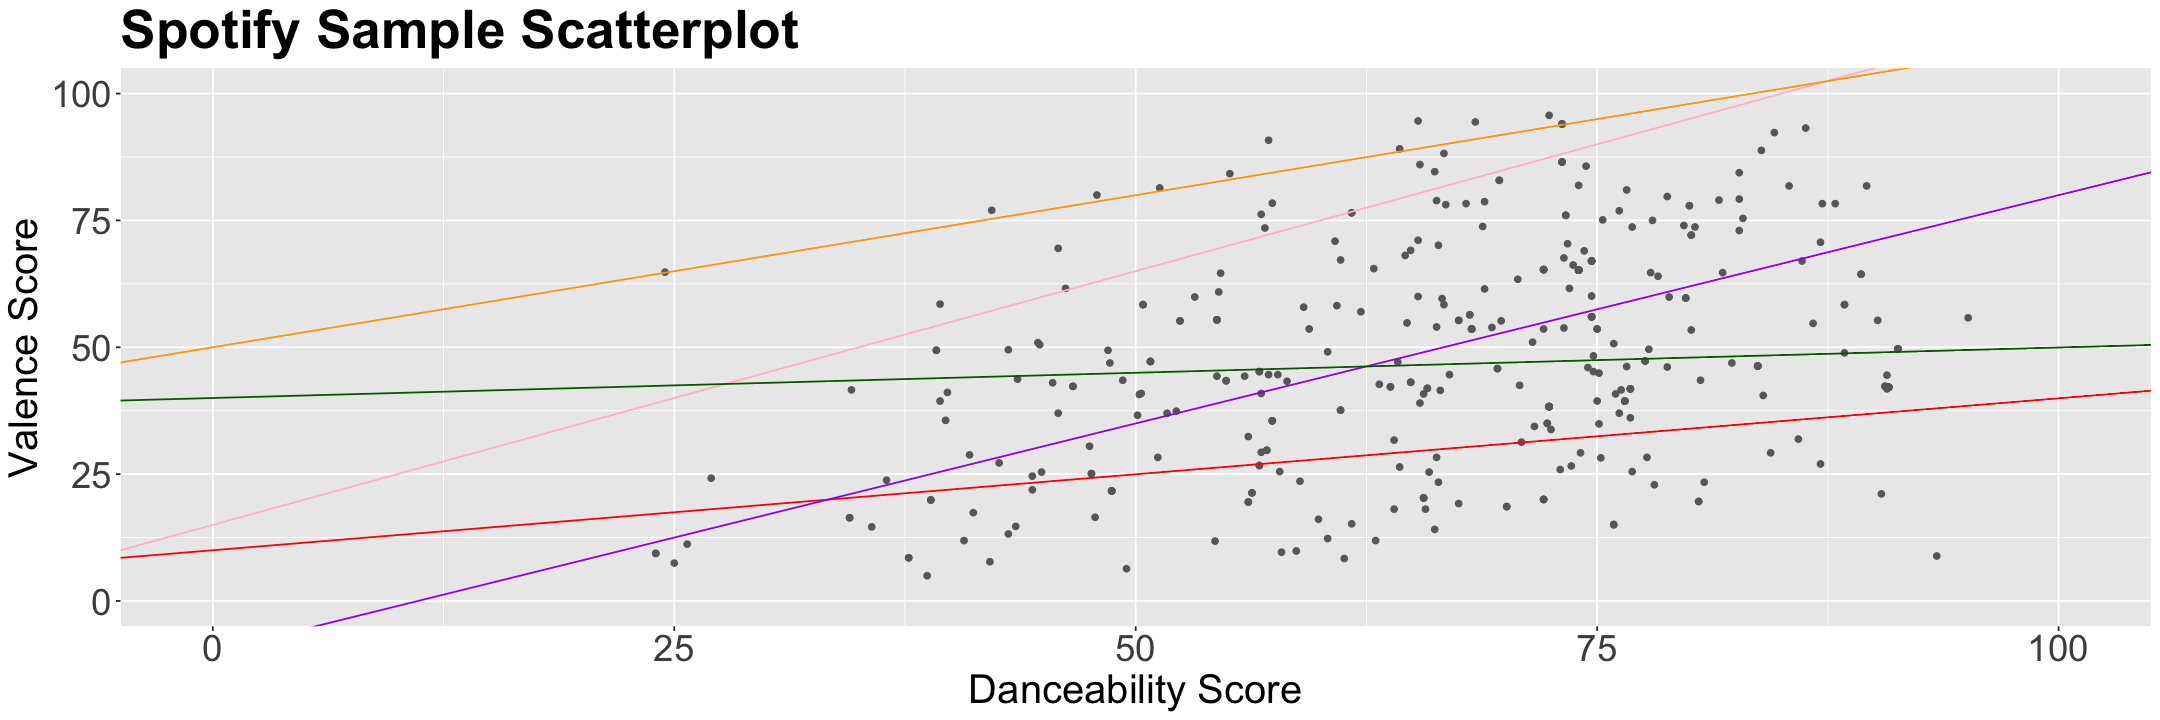

In [4]:
intro_estimation_scatterplot(data = spotify_training)

The plot above shows our **training data** and five different "regression lines" whose intercept and coefficient were deliberately chosen. **But, how can we choose the best line via this training data?**

### 4.1. Ordinary Least-Squares Estimates

Let us start digging into the estimation method: **ordinary least-squares (OLS)**. This method will use the **training data** $(x_i, y_i)$ to minimize the **loss function** called **sum of squared residuals (SSR)**:

$$\text{SSR}(\beta_0, \beta_1) = \sum_{i = 1}^n \big[ y_i - (\beta_0 + \beta_1 x_i) \big]^2$$

OLS provides the estimates $\hat{\beta}_0$ and $\hat{\beta}_1$ that minimize the above loss function. These estimates are obtained via partial derivates (i.e., we have an **optimization problem**!).

We will skip the proof since it is out of the scope of our lecture. Thus, the OLS closed forms are the following:

\begin{gather*}
\hat{\beta}_1 = \frac{\sum_{i = 1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i = 1}^n (x_i - \bar{x})^2} \\
\\
\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}
\end{gather*}

## 5. Modelling Results and Interpretation

The **estimated values** of our response `valence` are given by the following equation:

\begin{align*}
\overbrace{\hat{y}_i}^{\text{Estimated Valence/Positivity/Happiness}} &= \hat{\beta}_0 + \hat{\beta}_1 \overbrace{x_i}^{\text{Danceability}} \\
&= 13.43 + 0.53 x_i
\end{align*}

The values $\hat{\beta}_0$ and $\hat{\beta}_1$ yield the following:

$$\text{SSR}(\hat{\beta}_0, \hat{\beta}_1) = 143,242.7$$

The blue line below is called the **least-squares regression line**. We obtain it by plugging the `danceability` scores from the $x$-axis into this regression equation.

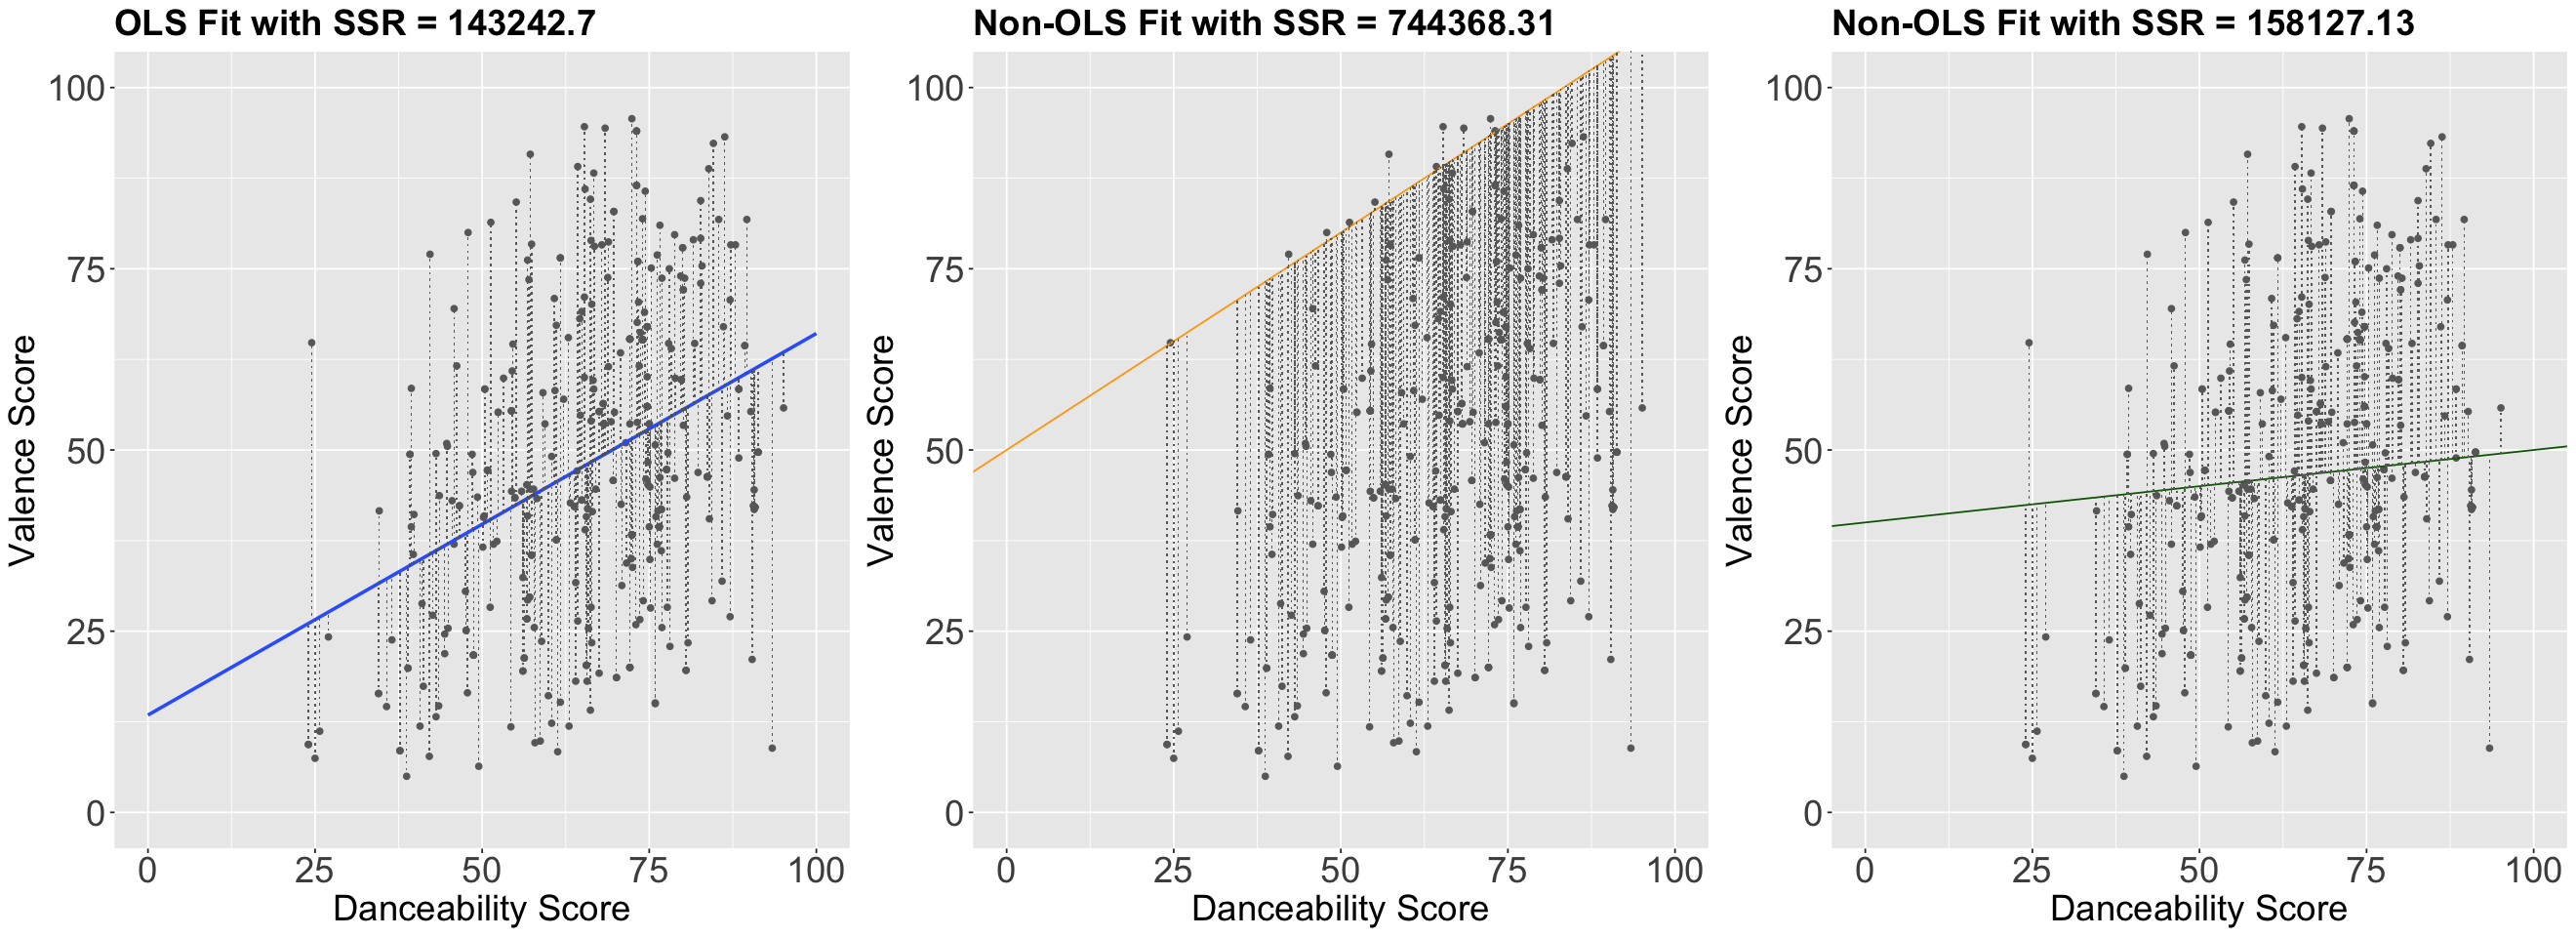

In [5]:
options(repr.plot.height = 8, repr.plot.width = 22)

plot_grid(OLS_scatterplot(data = spotify_training),
  non_OLS_scatterplot(data = spotify_training, beta_0 = 50, beta_1 = 0.6, colour = "orange"),
  non_OLS_scatterplot(data = spotify_training, beta_0 = 40, beta_1 = 0.1, colour = "darkgreen"),
  ncol = 3
)

We do not have to compute $\hat{\beta}_0$ and $\hat{\beta}_1$ by "hand." Instead, we can use the base `R` function called `lm()`. Moreover, `tidy()` from the package `broom` displays the modelling results in a "tidy" form.

In [6]:
OLS_model <- lm(formula = valence ~ danceability, data = spotify_training)
tidy(OLS_model) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),13.43,4.95,2.71,0.01
danceability,0.53,0.07,7.20,0.00


> **Heads-up:** Let us focus on the column `estimate` for now. The rest of the columns are part of a further topic related to **inference**.

#### Final In-Class Question

Recall your main statistical inquiry:

> Your team is interested in **quantifying** and **assessing** the **statistical dependence** of the **mean positivity/happiness** **as a FUNCTION of** the **danceability** within Spotify's music catalogue.

\begin{align*}
\overbrace{\hat{y}_i}^{\text{Estimated Valence/Positivity/Happiness}} &= \hat{\beta}_0 + \hat{\beta}_1 \overbrace{x_i}^{\text{Danceability}} \\
&= 13.43 + 0.53 x_i
\end{align*}

How can we address this inquiry with our previous results?

> We **estimate** that, for each one-unit increase in the **danceability** score, the **mean positivity/happiness** increases by 0.53 in the Spotify's catalogue.

## 6. Wrapping Up

- This lecture covered **estimation** via OLS in a simple linear regression context. We can expand this context to **multiple** continuous and discrete regressors.
- Our next stages are either **inference**, **prediction** or both!
- Model diagnostics are the last key stage in this modelling process.